In [5]:
from deepmol.pipeline import Pipeline

from deepmol.scalers import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from deepmol.models import SklearnModel
from deepmol.compound_featurization import MorganFingerprint, LayeredFingerprint
from sklearn.linear_model import RidgeClassifier

steps = [
         ('morgan fingerprints', MorganFingerprint(radius=2, size=1024, n_jobs=10)),
         ('random forest', SklearnModel(model=RidgeClassifier(random_state=42)))
         ]
pipeline_morgan_fp = Pipeline(steps=steps, path="morgan_fp")

pipeline_layered_fingerprints_baseline_ridge_classifier = Pipeline(steps=[('layered fingerprints', LayeredFingerprint()),
                                                                           ('ridge classifier', SklearnModel(model=RidgeClassifier(random_state=42)))])


2024-10-04 10:48:57.454559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 10:48:57.454611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 10:48:57.456118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 10:48:57.464286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:48:59.614265: W tensorflow/comp

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/deepmol/compound_featurization/__init__.py:20: UserWarning: Mol2Vec not available. Please install it to use it. (pip install git+https://github.com/samoturk/mol2vec#egg=mol2vec)
  warnings.warn("Mol2Vec not available. Please install it to use it. "


In [4]:
from deepmol.loaders import CSVLoader
import numpy as np


def fit_and_evaluate(pipeline):
    train = CSVLoader("train.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    valid = CSVLoader("valid.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("test.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    train_valid = train.merge([valid])
    pipeline.fit(train_valid)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric


    def macro_f1_score(y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro')

    def macro_precision_score(y_true, y_pred):
        return precision_score(y_true, y_pred, average='macro')

    def macro_recall_score(y_true, y_pred):
        return recall_score(y_true, y_pred, average='macro')


    results_test = pipeline.evaluate(test, metrics=[Metric(macro_f1_score), Metric(macro_precision_score), Metric(macro_recall_score)], per_task_metrics=False)
    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)
    for i in range(predictions.shape[1]):
        f1_score_task = f1_score(test.y[:, i], predictions[:, i])
        recall_score_task = recall_score(test.y[:, i], predictions[:, i])
        precision_score_task = precision_score(test.y[:, i], predictions[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
    
    results_test[0]['f1_scores_std'] = np.array(f1_scores).std()
    results_test[0]['recall_scores_std'] = np.array(recall_scores).std()
    results_test[0]['precision_scores_std'] = np.array(precision_scores).std()

    return results_test

In [5]:
import pandas as pd

pd.concat((pd.read_csv("train.csv"), pd.read_csv("valid.csv"))).to_csv("train_valid.csv", index=False)

In [6]:
from deepmol.loaders import CSVLoader

test = CSVLoader("test.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

test.y.shape

2024-09-17 11:47:50,733 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


(169, 29)

In [6]:
from deepmol.pipeline import Pipeline

pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')
pipeline_np_classifier = Pipeline.load('../np_classifier_fp')
pipeline_mhfp = Pipeline.load('../mhfp')
pipeline_neural_npfp = Pipeline.load('../neural_np_fp')

[10:49:10] Initializing Normalizer


In [2]:
pipeline_neural_npfp.steps

[('standardizer',
  <deepmol.standardizer.basic_standardizer.BasicStandardizer at 0x7f9dfda10cd0>),
 ('featurizer',
  <deepmol.compound_featurization.neural_npfp_generator.NeuralNPFP at 0x7f9dfd889630>),
 ('scaler',
  <deepmol.base.transformer.PassThroughTransformer at 0x7f9dfd889cf0>),
 ('feature_selector',
  <deepmol.base.transformer.PassThroughTransformer at 0x7f9dfd889db0>),
 ('model',
  SklearnModel(model=ClassifierChain(base_estimator=MLPClassifier(),
                                     order='random'),
               model_dir='../neural_np_fp/model/model.pkl'))]

In [3]:
pipeline_mhfp.steps

[('standardizer',
  <deepmol.standardizer.custom_standardizer.CustomStandardizer at 0x7fc26bcaa350>),
 ('featurizer', <deepmol.compound_featurization.mhfp.MHFP at 0x7f9dfd889060>),
 ('scaler',
  <deepmol.scalers.sklearn_scalers.PowerTransformer at 0x7f9dfd889210>),
 ('feature_selector',
  <deepmol.feature_selection.base_feature_selector.LowVarianceFS at 0x7f9dfd8892a0>),
 ('model',
  SklearnModel(model=RidgeClassifier(alpha=7.481630051502254),
               model_dir='../mhfp/model/model.pkl'))]

In [4]:
pipeline_np_classifier.steps

[('standardizer',
  <deepmol.standardizer.chembl_standardizer.ChEMBLStandardizer at 0x7fc1ebb9d630>),
 ('featurizer',
  <deepmol.compound_featurization.np_classifier_fp.NPClassifierFP at 0x7f9dfda10df0>),
 ('scaler',
  <deepmol.scalers.sklearn_scalers.QuantileTransformer at 0x7f9dfd85ebc0>),
 ('feature_selector',
  <deepmol.base.transformer.PassThroughTransformer at 0x7f9dfd85e710>),
 ('model',
  SklearnModel(model=RidgeClassifierCV(alphas=0.2818182626784553),
               model_dir='../np_classifier_fp/model/model.pkl'))]

In [13]:
print("Morgan FP")
results_pipeline_morgan_fp = fit_and_evaluate(pipeline_morgan_fp)
print("Layered FP and Ridge Classifier (optimized)")
results_pipeline_285 = fit_and_evaluate(pipeline_285)

print("NP classifier")
results_np_classifier_fp = fit_and_evaluate(pipeline_np_classifier)
print("MHFP")
results_mhfp = fit_and_evaluate(pipeline_mhfp)
print("Neural NP FP")
results_neural_np_fp = fit_and_evaluate(pipeline_neural_npfp)


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum i

In [15]:
import os
os.makedirs("results", exist_ok=True)

import pickle

with open("results/results_pipeline_morgan_fp.pkl", "wb") as f:
    pickle.dump(results_pipeline_morgan_fp, f)

with open("results/results_pipeline_285.pkl", "wb") as f:
    pickle.dump(results_pipeline_285, f)

with open("results/results_np_classifier_fp.pkl", "wb") as f:
    pickle.dump(results_np_classifier_fp, f)

with open("results/results_mhfp.pkl", "wb") as f:
    pickle.dump(results_mhfp, f)

with open("results/results_neural_np_fp.pkl", "wb") as f:
    pickle.dump(results_neural_np_fp, f)



In [4]:
# open the results
import pickle

with open("results/results_pipeline_morgan_fp.pkl", "rb") as f:
    results_pipeline_morgan_fp = pickle.load(f)

with open("results/results_pipeline_285.pkl", "rb") as f:
    results_pipeline_285 = pickle.load(f)

with open("results/results_np_classifier_fp.pkl", "rb") as f:
    results_np_classifier_fp = pickle.load(f)

with open("results/results_mhfp.pkl", "rb") as f:
    results_mhfp = pickle.load(f)

with open("results/results_neural_np_fp.pkl", "rb") as f:
    results_neural_np_fp = pickle.load(f)



In [5]:
import pandas as pd

results_mgcnn = pd.read_csv("results_mgcnn.csv")
pipeline_mgcnn_results = [results_mgcnn["f1_score"].mean(), results_mgcnn["precision"].mean(), results_mgcnn["recall"].mean()]
pipeline_mgcnn_results

[0.8313670437176287, 0.8334869398455086, 0.8714253464803721]

In [12]:
color_map = {
    'Layered FP + Ridge Classifier': (0.0, 0.45, 0.7),  # Strong blue
    'Morgan FP + Ridge Classifier': (0.95, 0.9, 0.25),  # Golden yellow
    'Morgan FP + MLP': (0.35, 0.7, 0.9),  # Light cyan
    'MGCNN (Eguchi et al. 2019)': (0.8, 0.47, 0.74),  # Light purple
    'Neural NPFP + MLPs (Classifier Chain)': (0.0, 0.6, 0.5),  # Strong teal (greenish-blue)
    'MHFP + Ridge Classifier': (0.6, 0.3, 0.0),  # Dark brown-orange
    'NPClassifierFP + Ridge Classifier': (0.6, 0.6, 0.6),  # Neutral gray
}


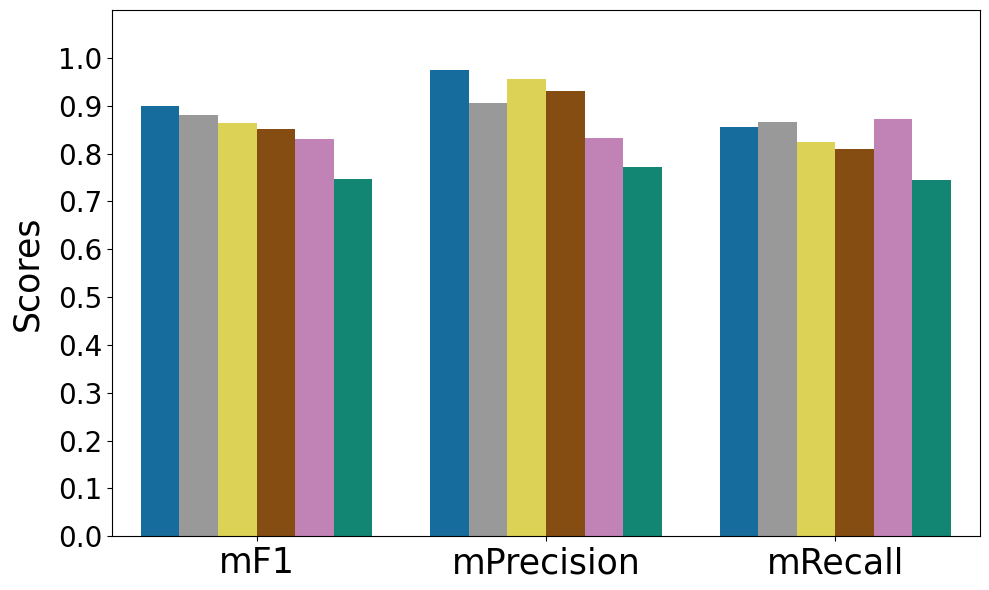

In [13]:
# plot the results of the three pipelines
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['savefig.transparent'] = True

labels = ['macro_f1_score', 'macro_precision_score', 'macro_recall_score']
pipeline_285_results = [results_pipeline_285[0]['macro_f1_score'], results_pipeline_285[0]['macro_precision_score'], results_pipeline_285[0]['macro_recall_score']]
pipeline_morgan_fp_results = [results_pipeline_morgan_fp[0]['macro_f1_score'], results_pipeline_morgan_fp[0]['macro_precision_score'], results_pipeline_morgan_fp[0]['macro_recall_score']]
pipeline_np_classifier_results = [results_np_classifier_fp[0]['macro_f1_score'], results_np_classifier_fp[0]['macro_precision_score'], results_np_classifier_fp[0]['macro_recall_score']]
pipeline_neural_npfp_results = [results_neural_np_fp[0]['macro_f1_score'], results_neural_np_fp[0]['macro_precision_score'], results_neural_np_fp[0]['macro_recall_score']]
pipeline_mhfp_results = [results_mhfp[0]['macro_f1_score'], results_mhfp[0]['macro_precision_score'], results_mhfp[0]['macro_recall_score']]

pipeline_285_std = [results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['recall_scores_std']]
pipeline_morgan_fp_std = [results_pipeline_morgan_fp[0]['f1_scores_std'], results_pipeline_morgan_fp[0]['precision_scores_std'], results_pipeline_morgan_fp[0]['recall_scores_std']]
pipeline_np_classifier_std = [results_np_classifier_fp[0]['f1_scores_std'], results_np_classifier_fp[0]['precision_scores_std'], results_np_classifier_fp[0]['recall_scores_std']]
pipeline_mgcnn_results_std = [results_mgcnn["f1_score"].std(), results_mgcnn["precision"].std(), results_mgcnn["recall"].std()]
pipeline_neural_npfp_std = [results_neural_np_fp[0]['f1_scores_std'], results_neural_np_fp[0]['precision_scores_std'], results_neural_np_fp[0]['recall_scores_std']]
pipeline_mhfp_std = [results_mhfp[0]['f1_scores_std'], results_mhfp[0]['precision_scores_std'], results_mhfp[0]['recall_scores_std']]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data setup (replace with your actual data)
# Assuming you have your pipeline results as separate lists like before
# Here's how you might structure them into a DataFrame:

data = {
    "Label": labels * 6,  # Repeat 'labels' for each pipeline
    "Scores": np.concatenate([
        pipeline_285_results,
        pipeline_np_classifier_results,
        pipeline_morgan_fp_results,
        pipeline_mhfp_results,
        pipeline_mgcnn_results,
        pipeline_neural_npfp_results,
    ]),
    "STD": np.concatenate([
        pipeline_285_std,
        pipeline_np_classifier_std,
        pipeline_morgan_fp_std,
        pipeline_mhfp_std,
        pipeline_mgcnn_results_std,
        pipeline_neural_npfp_std
        
    ]),
    "Pipeline": (
        ["Layered FP + Ridge Classifier"] * len(labels) +
        ["NPClassifierFP + Ridge Classifier"] * len(labels) +
        ["Morgan FP + Ridge Classifier"] * len(labels) +
        ["MHFP + Ridge Classifier"] * len(labels) +
         ["MGCNN (Eguchi et al. 2019)"] * len(labels) +
        ["Neural NPFP + MLPs (Classifier Chain)"] * len(labels)
        
    )
}

df = pd.DataFrame(data)
#df.sort_values(by="Scores", ascending=False, inplace=True)  # Sort by scores for better visualization

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(data=df, x="Label", y="Scores", hue="Pipeline", dodge=True, palette=color_map)

for i, p in enumerate(barplot.patches):
    # Calculate annotation text position
    if p.get_height() != 0:
        x = p.get_x() + p.get_width() / 2
        # Get the corresponding standard deviation from the DataFrame
        std = df.loc[i % len(df), 'STD']  # Adjust index for std
        # Add error bar for this bar using plt.errorbar
        # plt.errorbar(x, p.get_height(), yerr=std, fmt='none', capsize=5, color='black')

        # barplot.annotate(format(p.get_height(), '.3f'),  # Text to display
        #                 (p.get_x() + p.get_width() / 2., p.get_height() + 0.09),  # Position
        #                 ha='center', va='center',  # Center alignment
        #                 xytext=(0, 9),  # Distance from the top of the bar
        #                 textcoords='offset points',
        #                 size=20,  # Text size
        #                 rotation=90)  # Text rotation (90 degrees)

plt.title('', pad=20, size=25)  # Adjust title position
plt.ylabel('Scores', labelpad=10, size=25)  # Adjust y-axis label position
plt.xlabel('', labelpad=10, size=15)
# define other names for the ticks
plt.xticks([0, 1, 2], ['mF1', 'mPrecision', 'mRecall'], size=25)

legend = plt.legend(title='', bbox_to_anchor=(1.05, 1.15), loc='upper left', prop={'size': 25}, ncol=2)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("legend.png", dpi="figure", bbox_inches=bbox)
legend.remove()
        
plt.ylim(0, 1.1)  # Extend y-axis limit
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=20)  # Adjust y-axis ticks

plt.tight_layout()  # Adjust layout
#plt.show()
plt.savefig("scores_by_pipeline.png", dpi=400)

In [19]:
df.to_csv("scores_by_pipeline.csv", index=False)

In [27]:
pipeline_morgan_fp.steps[-1][1].model.coef_.shape

AttributeError: 'RidgeClassifier' object has no attribute 'coef_'

In [9]:
from sklearn.metrics import f1_score


def get_scores_by_task(pipeline):
    train = CSVLoader("train.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    valid = CSVLoader("valid.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("test.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    train_valid = train.merge([valid])
    pipeline.fit(train_valid)
    from sklearn.metrics import f1_score, precision_score, recall_score

    predictions = pipeline.predict(test)
    test = pipeline.transform(test)

    n_tasks = predictions.shape[1]
    tasks_f1_score = []
    tasks_precision = []
    tasks_recall = []
    for task in range(n_tasks):
        tasks_f1_score.append(f1_score(test.y[:, task], predictions[:, task]))
        tasks_precision.append(precision_score(test.y[:, task], predictions[:, task]))
        tasks_recall.append(recall_score(test.y[:, task], predictions[:, task]))

    return tasks_f1_score, tasks_precision, tasks_recall

In [8]:
from deepmol.loaders import CSVLoader

test = CSVLoader("test.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

labels = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine',
    'C00540': 'Cinnamoyl-CoA',
    'C01477': 'Apigenin',
    'C05903': 'Kaempferol',
    'C05904': 'Pelargonin',
    'C05905': 'Cyanidin',
    'C05908': 'Delphinidin',
    'C00389': 'Quercetin',
    'C01514': 'Luteolin',
    'C09762': "Liquiritigenin",
    'C00509': 'Naringenin',
    'C00223': 'p-Coumaroyl-CoA'
}
labels_names = [labels[name] for name in test.label_names]

2024-10-04 10:49:26,945 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [ ]:
f1_scores_285, precision_285, recall_285 = get_scores_by_task(pipeline_285)
f1_scores_morgan_fp, precision_morgan_fp, recall_morgan_fp = get_scores_by_task(pipeline_morgan_fp)
f1_scores_mhfp, precision_morgan_mhfp, recall_morgan_mhfp = get_scores_by_task(pipeline_mhfp)
f1_scores_np_classifier, precision_np_classifier, recall_np_classifier = get_scores_by_task(pipeline_np_classifier)
f1_scores_neural_npfp, precision_neural_npfp, recall_neural_npfp = get_scores_by_task(pipeline_neural_npfp)

import pandas as pd

results_mgcnn = pd.read_csv("results_mgcnn.csv")
f1_scores_mgcnn = results_mgcnn["f1_score"]

# plot the results of the three pipelines with heatmap
import seaborn as sns
import pandas as pd


In [11]:
f1_scores = [f1_scores_285, f1_scores_np_classifier, f1_scores_mhfp, f1_scores_morgan_fp, f1_scores_mgcnn, f1_scores_neural_npfp]
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]

df = pd.DataFrame(f1_scores, columns=labels_names, index=pipeline_names)

In [30]:
df.to_csv("scores_by_pipeline_by_task.csv", index=True)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("scores_by_pipeline_by_task.csv", index_col=0)

In [12]:
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]


df.index = pipeline_names
df

,L-Methionine,Tryptophan,L-Phenylalanine,L-Tyrosine,Dimethylallyl diphosphate,Geranyl diphosphate,Geranylgeranyl diphosphate,Farnesyl diphosphate,Campesterol,Indoleglycerol phosphate,...,L-Histidine,p-Coumaroyl-CoA,Naringenin,Cinnamoyl-CoA,Apigenin,Kaempferol,Pelargonin,Cyanidin,Delphinidin,Liquiritigenin
Layered FP + Ridge Classifier,1.0,0.975610,0.934783,0.950000,1.000000,1.000000,0.925926,0.705882,0.857143,1.000000,...,0.666667,0.888889,1.000000,0.814815,1.000000,1.0,1.0,1.0,1.0,1.0
NPClassifierFP + Ridge Classifier,1.0,0.900000,0.901099,0.842105,1.000000,0.769231,0.880000,0.625000,1.000000,0.800000,...,1.000000,0.727273,1.000000,0.642857,1.000000,1.0,1.0,1.0,1.0,1.0
MHFP + Ridge Classifier,1.0,0.883721,0.905263,0.947368,1.000000,0.727273,0.888889,0.555556,1.000000,0.500000,...,0.666667,0.800000,1.000000,0.666667,1.000000,1.0,1.0,1.0,1.0,1.0
Morgan FP + Ridge Classifier,1.0,0.952381,0.901099,0.974359,1.000000,0.833333,0.888889,0.588235,1.000000,0.500000,...,1.000000,0.888889,1.000000,0.827586,1.000000,1.0,1.0,1.0,1.0,1.0
MGCNN (Eguchi et al. 2019),1.0,0.952381,0.916667,0.923077,0.600000,0.666667,0.947368,0.888889,1.000000,0.857143,...,0.666667,0.727273,0.666667,0.620690,0.666667,1.0,1.0,1.0,1.0,1.0
Neural NPFP + MLPs (Classifier Chain),1.0,0.926829,0.903226,0.820513,0.857143,0.800000,0.943396,0.750000,0.857143,0.800000,...,0.000000,0.888889,1.000000,0.640000,1.000000,1.0,1.0,1.0,1.0,1.0


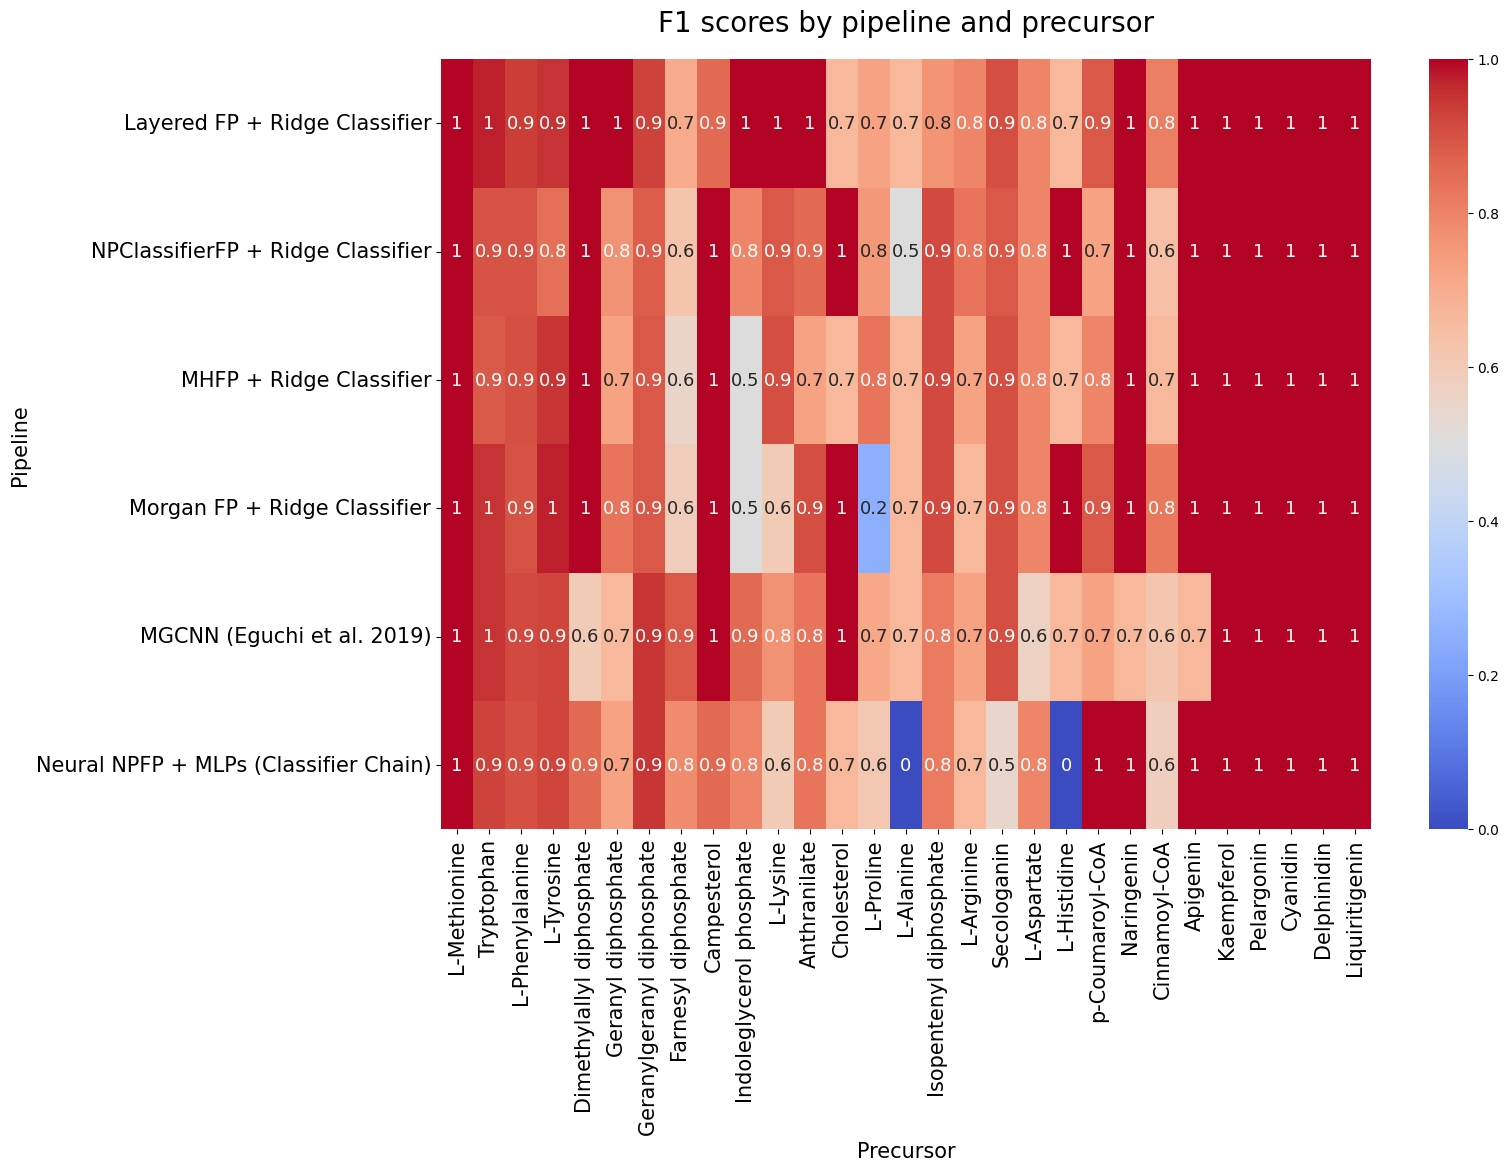

In [3]:
plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1g', annot_kws={"size": 13})
plt.title('F1 scores by pipeline and precursor', pad=20, size=20)
plt.xlabel('Precursor', size=15)
plt.ylabel('Pipeline', size=15)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig("f1_scores_by_pipeline_and_precursor.png", transparent=True)
plt.show()

In [23]:
# apply the wilcoxon test to all pairs of pipelines
import itertools
import scipy.stats as stats

df = pd.DataFrame(f1_scores, columns=labels_names, index=pipeline_names)

significant_differences_f1 = []
for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    p_value = stats.wilcoxon(df.loc[pipeline1, :], df.loc[pipeline2, :]).pvalue
    if p_value < 0.05:
        significant_differences_f1.append((pipeline1, pipeline2, "macro_f1_score", p_value))
                       

In [14]:
# apply the wilcoxon test to all pairs of pipelines
import itertools
import scipy.stats as stats

results_mgcnn = pd.read_csv("results_mgcnn.csv")
precision_mgcnn = results_mgcnn["precision"]

precision_scores = [precision_285, precision_np_classifier, precision_morgan_mhfp, precision_morgan_fp, precision_mgcnn, precision_neural_npfp]
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]

df = pd.DataFrame(precision_scores, columns=labels_names, index=pipeline_names)

significant_differences_precision = []
for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    p_value = stats.wilcoxon(df.loc[pipeline1, :], df.loc[pipeline2, :]).pvalue
    if p_value < 0.05:
        significant_differences_precision.append((pipeline1, pipeline2, "macro_precision_score", p_value))

/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [15]:
# apply the wilcoxon test to all pairs of pipelines
import itertools
import scipy.stats as stats
import pandas as pd

results_mgcnn = pd.read_csv("results_mgcnn.csv")
recall_mgcnn = results_mgcnn["recall"]

recall_scores = [recall_285, recall_np_classifier, recall_morgan_mhfp, recall_morgan_fp, recall_mgcnn, recall_neural_npfp]

df = pd.DataFrame(recall_scores, columns=labels_names, index=pipeline_names)

significant_differences_recall = []
for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    p_value = stats.wilcoxon(df.loc[pipeline1, :], df.loc[pipeline2, :]).pvalue
    if p_value < 0.05:
        significant_differences_recall.append((pipeline1, pipeline2, "macro_recall_score", p_value))
    

/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [16]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [26]:
for pipeline1, pipeline2, metric, pvalue in significant_differences_f1:
    print(f"{pipeline1} vs {pipeline2} for {metric}: p-value = {pvalue} {convert_pvalue_to_asterisks(pvalue)}")

significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, _, pvalue in significant_differences_f1]

significant_differences_f1_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (F1 score)"])

Layered FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_f1_score: p-value = 0.03110019751085829 *
Layered FP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain) for macro_f1_score: p-value = 0.0013924203980061277 **
NPClassifierFP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain) for macro_f1_score: p-value = 0.029757911023203625 *


In [28]:
for pipeline1, pipeline2, metric, pvalue in significant_differences_precision:
    print(f"{pipeline1} vs {pipeline2} for {metric}: p-value = {pvalue} {convert_pvalue_to_asterisks(pvalue)}")

significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, _, pvalue in significant_differences_precision]

significant_differences_precision_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (Precision score)"])

Layered FP + Ridge Classifier vs NPClassifierFP + Ridge Classifier for macro_precision_score: p-value = 0.017427406880717998 *
Layered FP + Ridge Classifier vs MHFP + Ridge Classifier for macro_precision_score: p-value = 0.04898202741703731 *
Layered FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_precision_score: p-value = 0.00197537701747741 **
Layered FP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain) for macro_precision_score: p-value = 0.001214807730917718 **
MHFP + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_precision_score: p-value = 0.019888137642811263 *
Morgan FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_precision_score: p-value = 0.005191477473440576 **
Morgan FP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain) for macro_precision_score: p-value = 0.010428224435337068 *


In [29]:
for pipeline1, pipeline2, metric, pvalue in significant_differences_recall:
    print(f"{pipeline1} vs {pipeline2} for {metric}: p-value = {pvalue} {convert_pvalue_to_asterisks(pvalue)}")

significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, _, pvalue in significant_differences_recall]

significant_differences_recall_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (Recall score)"])

Layered FP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain) for macro_recall_score: p-value = 0.01584230210517771 *
NPClassifierFP + Ridge Classifier vs Neural NPFP + MLPs (Classifier Chain) for macro_recall_score: p-value = 0.01982819845488383 *
MHFP + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_recall_score: p-value = 0.028263033165028862 *
MGCNN (Eguchi et al. 2019) vs Neural NPFP + MLPs (Classifier Chain) for macro_recall_score: p-value = 0.0031280621591040884 **


In [30]:
import pandas as pd

def generate_plain_latex_table(df):
    # Start LaTeX table
    latex_table = "\\begin{table}[htbp]\n\\centering\n\\begin{tabular}{|" + "c|" * len(df.columns) + "}\n\\hline\n"
    
    # Add column headers
    headers = ' & '.join(df.columns) + " \\\\\n\\hline\n"
    latex_table += headers

    # Add rows with values from the DataFrame
    for index, row in df.iterrows():
        row_data = ' & '.join(map(str, row)) + " \\\\\n\\hline\n"
        latex_table += row_data
    
    # End LaTeX table
    latex_table += "\\end{tabular}\n\\caption{Significant Differences Table}\n\\end{table}"

    return latex_table

latex_code = generate_plain_latex_table(df=significant_differences_f1_df)
print(latex_code)

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (F1 score) \\
\hline
Layered FP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & * \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
NPClassifierFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}


In [31]:

latex_code = generate_plain_latex_table(df=significant_differences_precision_df)
print(latex_code)

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (Precision score) \\
\hline
Layered FP + Ridge Classifier & NPClassifierFP + Ridge Classifier & * \\
\hline
Layered FP + Ridge Classifier & MHFP + Ridge Classifier & * \\
\hline
Layered FP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & ** \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
MHFP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & * \\
\hline
Morgan FP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & ** \\
\hline
Morgan FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}


In [32]:

latex_code = generate_plain_latex_table(df=significant_differences_recall_df)
print(latex_code)

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (Recall score) \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
NPClassifierFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
MHFP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & * \\
\hline
MGCNN (Eguchi et al. 2019) & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}
